# Ideas

More options:

- Pay as much as the second highest bidder?
- Different way of doing locations
- Base prices can change based on market data
- Real data
- Interest rate can change per month
- Variabele inflatie

More visualizations:

- Dates on x-axis instead of month number
- Average time to sell a house.
- Proportion of homeless people.
- Total transaction volume per step.
- Buyers, houses and sales not cummulative

In [3]:
pip install mesa


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 3.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 3.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 MB 3.6 MB/s eta 0:00:0000:0100:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 3.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 2.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 2.9 MB/s eta 0:00:00a 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


## Imports

In [6]:
import mesa
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

## Data Loading

In [7]:
# data from https://fred.stlouisfed.org/series/REAINTRATREARAT10Y#0
# the data is the interest rate per month for all 120 months starting from 2013 till the end of 2023

df_interest = pd.read_csv('data_interest_rate.csv')
df_interest.drop([df_interest.index[120]], inplace=True)
df_interest.rename(columns={'Index': 'date'}, inplace=True)
display(df_interest.head())

df_inflation = pd.read_csv('inflation_data.csv')
df_inflation.drop([df_inflation.index[120]], inplace=True)
df_inflation.rename(columns={'observation_date': 'date',
                             'T10YIE': 'inflation_rate'}, inplace=True)
display(df_inflation.head())

,date,interest_rate
0,01/01/2013,0.084401
1,01/02/2013,0.172100
2,01/03/2013,0.050341
3,01/04/2013,-0.024212
4,01/05/2013,-0.019391


,date,inflation_rate
0,01/01/2013,2.52
1,01/02/2013,2.55
2,01/03/2013,2.54
3,01/04/2013,2.41
4,01/05/2013,2.28


## Classes

In [36]:
class Buyer(mesa.Agent):
    def __init__(self, model, salary: float, savings: float, age: float, dual_income: bool, preferred_location: str):
        super().__init__(model)
        self.salary = salary * 1.5 if dual_income else salary # assume dual_income increases salary by 50%
        self.savings = savings
        self.age = age
        self.dual_income = dual_income
        self.preferred_location = preferred_location
        self.budget = self.calculate_budget()
        
    def calculate_budget(self):
        mean_willing_to_pay_percentage = 1
        std_willing_to_pay_percentage = 0.1
        multiplier = np.random.normal(mean_willing_to_pay_percentage, std_willing_to_pay_percentage)
        # use age as a indicator of how much willing to pay and add some randomness
        willing_to_pay_percentage = (0.3 - (0.10 * (self.age - 20) / 40)) * multiplier
        
        payments = 360 # assume a 30 year morgage: 12 months * 30 years = 360
    
        down_payment_percentage = 0.20  # Assume 20% down payment
        down_payment = self.savings * down_payment_percentage

        max_monthly_payment = self.salary / 12 * willing_to_pay_percentage
        loan_amount = (max_monthly_payment * ((1 + INTEREST_RATE_MONTHLY)**payments - 1)) / \
                      (INTEREST_RATE_MONTHLY * (1 + INTEREST_RATE_MONTHLY)**payments)
        
        # Total budget is the loan amount plus the down payment
        total_budget = loan_amount + down_payment
        
        return total_budget

class House(mesa.Agent):
    def __init__(self, model, location: str, size: int):
        super().__init__(model)
        self.location = location
        self.size = size
        self.market_price = self.calculate_market_price()
    
    def calculate_market_price(self):
        # Base price per square unit (adjust based on location)
        base_price_per_sqm = {
        "urban": 5_000,
        "suburban": 3_000,
        "rural": 1_500,
        }[self.location]
    
        # Calculate the total price based on size
        price = base_price_per_sqm * self.size
        return price

class Market(mesa.Model):
    def __init__(self, num_buyers, num_houses):
        super().__init__()
        self.buyers = []
        self.houses = []
        self.sales = []
        self.time = 0
        self.buyer_counts = []
        self.house_counts = []
        self.sale_counts = []
        self.average_prices = []
        self.price_conf_intervals = []
        self.inflation = 1

        # Create initial buyers
        for _ in range(num_buyers):
            self.add_buyer()

        # Create initial houses
        for _ in range(num_houses):
            self.add_house()

    def add_buyer(self):
        savings = random.uniform(0, 100_000) # add realistic savings
        kill_agents = []
        # age data found at https://datacenter.aecf.org/data/tables/6538-adult-population-by-age-group#detailed/1/any/false/36/117,2801,2802,2803/13515,13516
        # education data found at https://nces.ed.gov/programs/coe/indicator/cba/annual-earnings and https://www.census.gov/newsroom/press-releases/2022/educational-attainment.html 
        # NOTE: The salary of males and females are combined into an average
        age_group = random.choices(['18-24','25-64','65+'], weights=[0.13, 0.69, 0.18], k=1)[0]
        edu_group = random.choices(['hs', 'ass', 'bac'], weights=[45, 17, 38], k=1)[0]
        if age_group == '18-24':
                age = random.randint(18, 24)
        elif age_group == '25-64':
                age = random.randint(25, 64)
        else:
                age = random.randint(65, 80)
        # death rates by age data found at: https://www.cdc.gov/nchs/products/databriefs/db492.htm
        if age in range(18, 24): 
            death_rate = 80/100000

        elif age in range(25, 34):
            death_rate = 163.4/100000

        elif age in range(35, 44):
            death_rate = 255.4/100000
            
        elif age in range(45, 54): 
            death_rate = 453.3/100000
        
        elif age in range(55, 64):
            death_rate = 992.1/100000
        
        elif age in range(65, 74):
            death_rate = 1978.7/100000
        
        elif age in range(75, 84):
            death_rate = 4708.2/100000
        
        else:
            death_rate = 14389.6/100000

        # pension calculation found at https://equable.org/pension-basics-how-pension-benefits-are-calculated/
        # average age for a degree found at https://learn.org/articles/normal_age_finish_college.html
        if age_group != '65+':
                if edu_group == 'hs':
                    mean_salary = 42100 * (1 + self.inflation / 100)
                elif edu_group == 'ass':
                    mean_salary = 50600 * (1 + self.inflation / 100)
                else:
                    mean_salary = 68500 * (1 + self.inflation / 100)
        else:
                if edu_group == 'hs':
                    mean_salary = (random.randint(59, 65) - random.randint(17, 18)) * 0.02 * 42100 * (1 + self.inflation / 100)
                elif edu_group == 'ass':
                    mean_salary = (random.randint(59, 65) - random.randint(23, 29)) * 0.02 * 50600 * (1 + self.inflation / 100)
                else:
                    mean_salary = (random.randint(59, 65) - random.randint(23, 29)) * 0.02 * 68500 * (1 + self.inflation / 100) 
        
        dual_income = random.random() < 0.3  # 30% dual income households
        preferred_location = random.choices(["urban", "suburban", "rural"], weights=[0.5, 0.3, 0.2], k=1)[0]
        buyer = Buyer(self, mean_salary, savings, age, dual_income, preferred_location)
        self.buyers.append(buyer)
        self.agents.add(buyer)
        print(age, mean_salary)
        if random.random() < death_rate:
            print(f"Buyer aged {age} has died.")
            self.buyers.remove(buyer)
            self.agents.remove(buyer)

    def add_house(self):
        location = random.choices(["urban", "suburban", "rural"], weights= [0.5, 0.3, 0.2], k=1)[0]
        
        mean_size = 150
        std_dev_size = 50
        size = int(np.clip(np.random.normal(mean_size, std_dev_size), 50, 300))
        
        house = House(self, location, size)
        self.houses.append(house)
        self.agents.add(house)
    
    def step(self):
        # each time step is one month
        self.time += 1
        
        for _ in range(random.randint(0, int(NUM_BUYERS * 0.08))): self.add_buyer() # add realistic chances
        for _ in range (random.randint(0, int(NUM_HOUSES * 0.07))): self.add_house() # add realistic chances
        
        self.agents.shuffle_do('step')

        # Salaries increase slightly
        for buyer in self.buyers:
            buyer.salary *= 1.001  # add realistic number
            buyer.age += 0.08333 # 1/12 of a year
            buyer.savings += buyer.budget * 0.1  # Assume 10% of monthly money is saved

        self.market_model()
                
        self.buyer_counts.append(len(self.buyers))
        self.house_counts.append(len(self.houses))
        self.sale_counts.append(len(self.sales))
        
        # Calculate average house price and confidence interval
        if self.sales:
            prices = [list(sale.values())[0].budget for sale in self.sales]
            avg_price = np.mean(prices)
            conf_interval = 1.96 * np.std(prices) / np.sqrt(len(prices))
            self.average_prices.append(avg_price)
            self.price_conf_intervals.append(conf_interval)
        else:
            self.average_prices.append(0)
            self.price_conf_intervals.append(0)
    
    def market_model(self):
        # Group houses and buyers by location
        location_houses = defaultdict(list)
        for house in self.houses:
            location_houses[house.location].append(house)
        for loc in location_houses:
            location_houses[loc].sort(key=lambda x: -x.size)  # Sort by size (largest first)

        location_buyers = defaultdict(list)
        for buyer in self.buyers:
            location_buyers[buyer.preferred_location].append(buyer)
        for loc in location_buyers:
            location_buyers[loc].sort(key=lambda x: -x.budget)  # Sort by budget (highest first)

        # Process transactions
        sold_houses = []
        successful_buyers = []
        for loc in location_houses:
            houses = location_houses[loc]
            buyers = location_buyers[loc]
            for house in houses:
                if not buyers:
                    break  # No buyers left for this location
                
                # Find the highest bidder
                winning_buyer = buyers[0]
                
                # Check if the bid is acceptable (e.g., at least 80% of market price)
                if winning_buyer.budget >= 0.8 * house.market_price:
                    sold_houses.append(house)
                    successful_buyers.append(winning_buyer)
                    self.sales.append({house: winning_buyer})
                    # print(f"House in {house.location} (size={house.size}) sold to buyer aged {int(winning_buyer.age)} for ${int(winning_buyer.budget):,} (Market Price: ${int(house.market_price):,})")
                    buyers.pop(0)  # Remove the winning buyer
                # else:
                #     print(f"House in {house.location} (size={house.size}) not sold. Highest bid (${int(winning_buyer.budget):,}) was below 80% of market price (${int(house.market_price):,}).")

        # Remove transacted entities
        for house in sold_houses:
            self.houses.remove(house)
            self.agents.remove(house)
        for buyer in successful_buyers:
            self.buyers.remove(buyer)
            self.agents.remove(buyer)
    
    def visualize(self):
        plt.figure(figsize=(10, 5))
        plt.plot(range(self.time), self.buyer_counts, label="Total Buyers")
        plt.plot(range(self.time), self.house_counts, label="Total Houses")
        plt.plot(range(self.time), self.sale_counts, label="Total Sales")
        plt.title("Market Dynamics Over Time")
        plt.xlabel("Month")
        plt.ylabel("Count")
        plt.legend()
        plt.show()
        
        plt.figure(figsize=(10, 5))
        plt.errorbar(range(self.time), self.average_prices, yerr=self.price_conf_intervals, 
                    fmt='-o', label="Average Price", ecolor='grey')
        plt.title("Home Price Trends with 95% Confidence Intervals")
        plt.xlabel("Month")
        plt.ylabel("Price ($)")
        plt.legend()
        
        plt.figure(figsize=(10, 5))
        prices_list = [list(sale.values())[0].budget for sale in self.sales]
        prices_list = [price for price in prices_list if price]
        plt.hist(prices_list, bins=20, alpha=0.7, color='blue', label='House Prices')
        plt.title("House Price Distribution per Step")
        plt.xlabel("Price ($)")
        plt.ylabel("Frequency")
        plt.legend()
        plt.show()

## Running the simulation

In [37]:
INTEREST_RATE_MONTHLY = 0.04 / 12
NUM_BUYERS = 8_000
NUM_HOUSES = 3_000

market = Market(NUM_BUYERS, NUM_HOUSES)

for _ in range(120):
    market.step()

36 69185.0
49 42521.0
23 69185.0
21 69185.0
29 69185.0
64 69185.0
61 42521.0
54 69185.0
32 69185.0
79 49813.2
57 42521.0
44 42521.0
32 51106.0
74 36568.06
Buyer aged 74 has died.
24 69185.0
Buyer aged 24 has died.
59 69185.0
19 42521.0
20 69185.0
43 69185.0
48 42521.0
43 69185.0
26 51106.0
69 39119.32
31 42521.0
41 51106.0
36 42521.0
58 69185.0
47 42521.0
74 34752.08
Buyer aged 74 has died.
34 51106.0
71 39119.32
57 42521.0
67 37418.48
24 42521.0
25 69185.0
21 42521.0
54 42521.0
38 69185.0
51 69185.0
70 40820.16
63 51106.0
47 51106.0
20 69185.0
35 51106.0
65 51196.9
58 51106.0
38 69185.0
74 37418.48
33 69185.0
19 42521.0
40 69185.0
21 42521.0
19 69185.0
49 42521.0
29 51106.0
26 69185.0
21 69185.0
27 42521.0
24 42521.0
51 42521.0
55 42521.0
19 51106.0
39 42521.0
22 69185.0
80 35717.64
34 51106.0
68 36796.32
50 69185.0
50 42521.0
18 42521.0
57 42521.0
21 42521.0
58 69185.0
57 42521.0
48 51106.0
63 69185.0
43 42521.0
64 51106.0
20 42521.0
75 38268.9
39 51106.0
44 69185.0
64 51106.0
55 425

## Visualisations

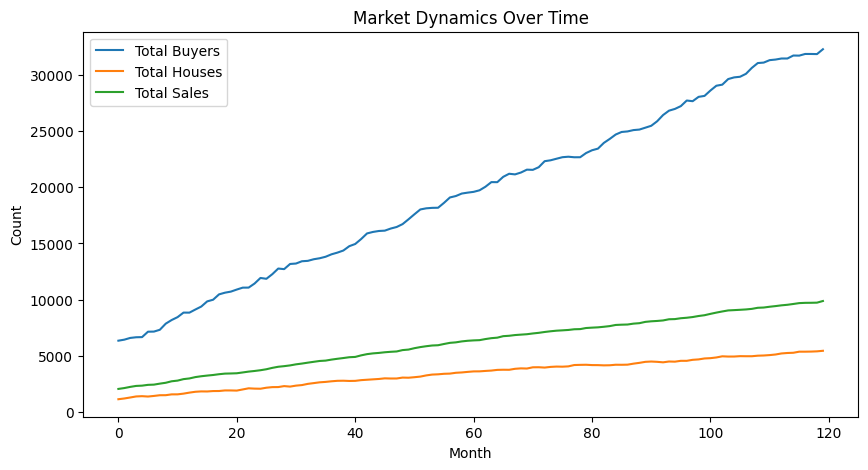

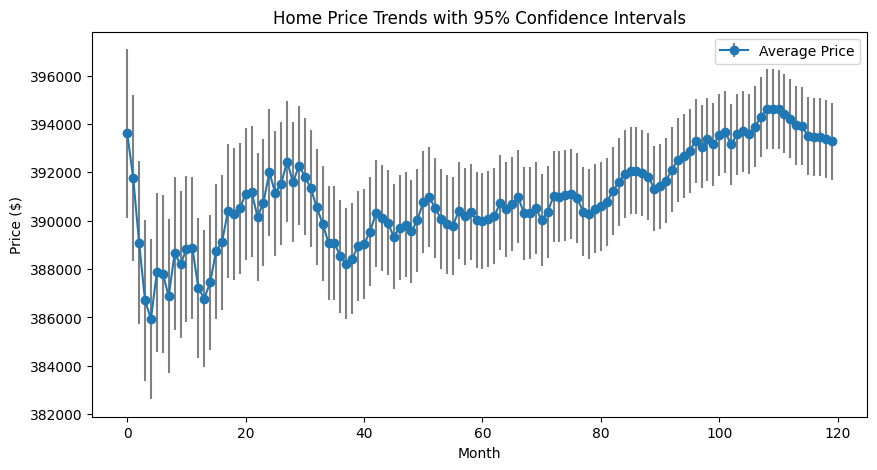

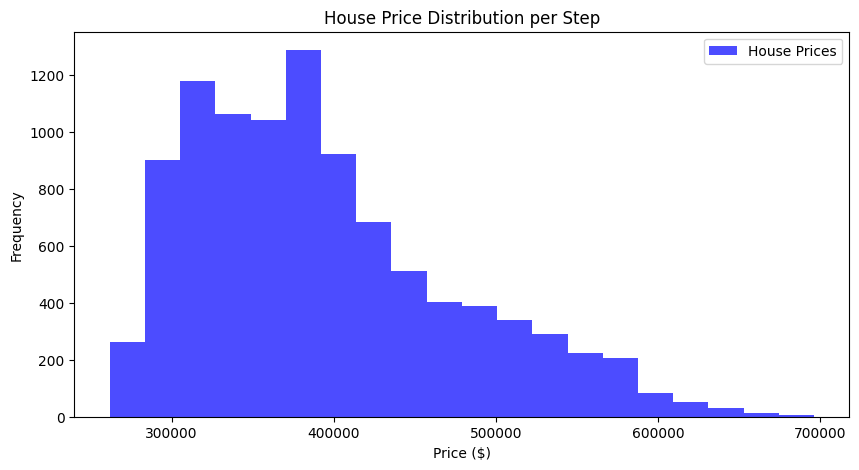

In [38]:
market.visualize()